In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
data = pd.read_csv('hochgerner_2018.data.gz',sep='\t',index_col=0)
anno = pd.read_csv('hochgerner_2018.anno',sep='\t',header=None)
anno = anno[1].values


In [ ]:
import numpy as np
import gzip

with gzip.open('hochgerner_2018.data.gz', "rt") as f:  # 't' for text mode
    data = np.loadtxt(f)  # 或 np.genfromtxt(f, delimiter=',') 根据你的格式

print(data.shape)


In [324]:
#We will first normalize each cell by total count per cell.
percell_sum = data.sum(axis=0)
pergene_sum = data.sum(axis=1)

preprocessed_data = data / percell_sum.values[None, :] * np.median(percell_sum)
preprocessed_data = preprocessed_data.values

#transform the preprocessed_data array by `x := log (1+x)`
preprocessed_data = np.log(1 + preprocessed_data)

#standard scaling
preprocessed_data_mean = preprocessed_data.mean(axis=1)
preprocessed_data_std = preprocessed_data.std(axis=1)
preprocessed_data = (preprocessed_data - preprocessed_data_mean[:, None]) / \
                     preprocessed_data_std[:, None]



In [325]:
#preprocess by PCA 
from sklearn.decomposition import PCA
pca = PCA(n_components = 20)
pca.fit(preprocessed_data.T)
pca_data = pca.transform(preprocessed_data.T)

Text(0, 0.5, 'PC2')

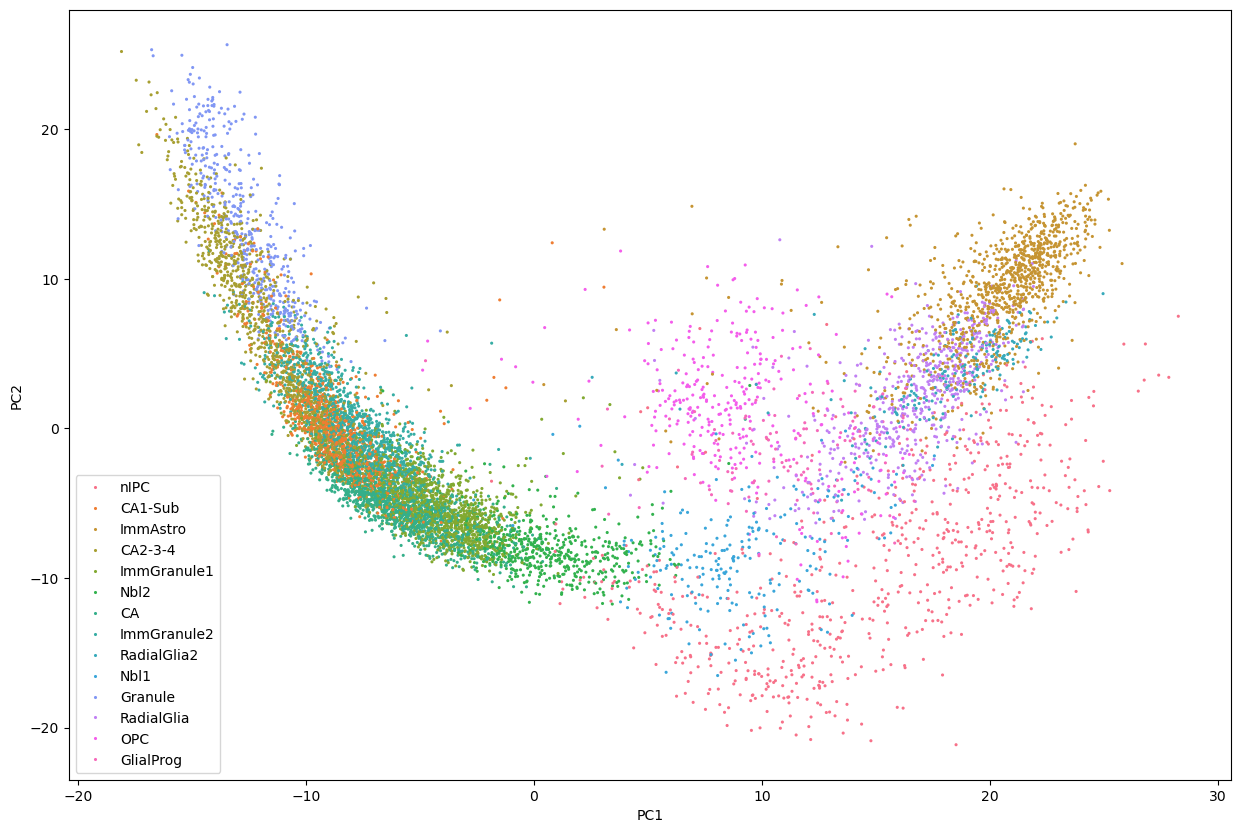

In [326]:
#visualize PCA result
plt.figure(figsize=(15,10))
sns.scatterplot(x=pca_data[:,0], y=pca_data[:,1], linewidth = 0, s=5, hue=anno)
plt.xlabel('PC1')
plt.ylabel('PC2')

In [327]:
import plotly.express as px
fig = px.scatter_3d(x=pca_data[:,0], y=pca_data[:,1], z=pca_data[:,2],color=anno,opacity = 0.5)
fig.update_traces(marker_size=2.5)
fig.show()

##  GraphDR: nonlinear dimensionality reduction that preserves linear interpretability

GraphDR is a nonlinear dimensionality reduction method that preserves the linear interpretability while improving on cell type representation quality. GraphDR combines the advantages of linear methods such as PCA and nonlinear methods such as t-SNE. Unlike t-SNE, GraphDR is also suitable for comparison across datasets.

In [328]:
#write and apply your own GraphDR implementation here!

def graphdr(pca_data, 
            lambda_ = 0.001, 
            no_rotation=True,
            n_neighbor = 3000,
            top_d_eigenvector = 10):
    """
    Input:
        X (or pca_data)

    Parameters:
        lambda_ : 
        no_rotation: if True, "top_d_eigenvector" doesn't work and W matrix is an identity matrix
        n_neighbor: when constructing kneighbors graph
        top_d_eigenvector: top d eigenvectors of W if rotation is True

    Return:
        Z  (Z = (I + lambda_*L)^-1 @ X @ W)

    
    """
    from sklearn.neighbors import kneighbors_graph
    from scipy.sparse.csgraph import laplacian
    from scipy.sparse import eye
    from numpy.linalg import inv


    n, d = pca_data.shape
    
    X = pca_data
    I = eye(n).toarray()
    G = kneighbors_graph(X, n_neighbors = n_neighbor).toarray()
    L = laplacian(G, symmetrized=True) 

    K =  inv(I + lambda_ * L)
    
    if no_rotation:
        W = eye(d).toarray()
    else:
        W_ = X.T @ K @ X
        _, W = np.linalg.eig(W_)
        W = W[:,:top_d_eigenvector]

    Z = K @ X @ W

    return Z
    

graphdr_data  = graphdr(pca_data, lambda_= 5, no_rotation=True, n_neighbor = 10, top_d_eigenvector = 5)

Text(0, 0.5, 'GraphDR 2')

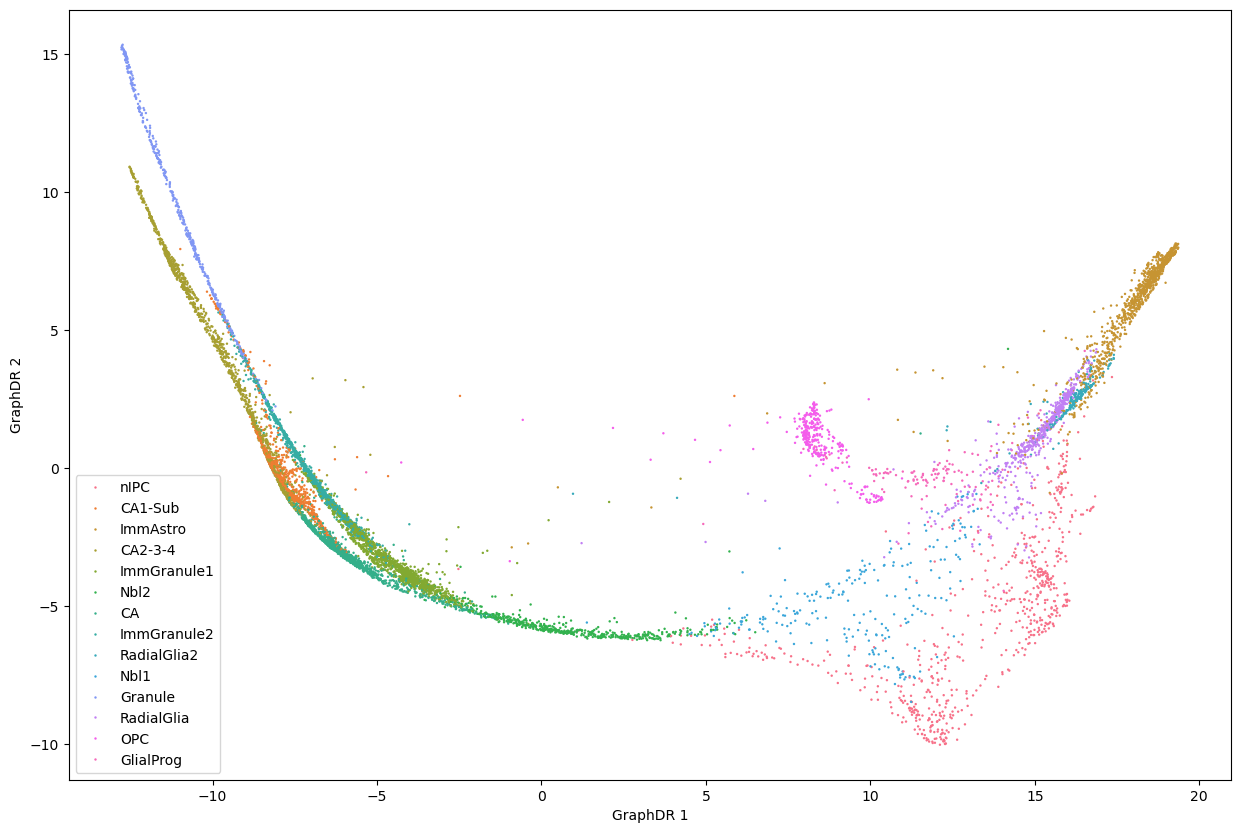

In [329]:
#compare your graphdr output with this one, it should look similar (remember to adjust lambda_ and see its effect)

plt.figure(figsize=(15,10))
sns.scatterplot(x=graphdr_data[:,0], y=graphdr_data[:,1], linewidth = 0, s=3, hue=anno)
plt.xlabel('GraphDR 1')
plt.ylabel('GraphDR 2')

In [330]:
import plotly.graph_objects as go

fig = px.scatter_3d(x=graphdr_data[:,0], y=graphdr_data[:,1], z=graphdr_data[:,2],color=anno,opacity = 0.5)
fig.update_traces(marker_size=2.5)
fig.show()

# play with plotly

In [273]:
from dash import Dash, dcc, html, Input, Output
import plotly.express as px

app = Dash(__name__)

app.layout = html.Div([
    html.H4('Analysis of Iris data using scatter matrix'),
    dcc.Dropdown(
        id="plotly-express-x-dropdown",
        options=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
        value=['sepal_length', 'sepal_width'],
        multi=True
    ),
    dcc.Graph(id="plotly-express-x-graph"),
])


@app.callback(
    Output("plotly-express-x-graph", "figure"),
    Input("plotly-express-x-dropdown", "value"))
def update_bar_chart(dims):
    #df = px.data.iris() # replace with your own data source
    fig = px.scatter_3d(x=graphdr_data[:,0], y=graphdr_data[:, 1], z=graphdr_data[:,2],color=anno)
    return fig


In [274]:
app.run()